In [1]:
import wandb
import os
import umap
import torch
import umap.plot
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision.transforms import transforms
import pandas as pd
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from copy import deepcopy
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,RocCurveDisplay
from torch.nn.functional import normalize
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score,roc_curve
from pytorch_metric_learning import losses
from scipy import stats
import matplotlib.pyplot as plt


from utils import load_data, gene_signatures
from trainer import SimCLR, Trainer, classifier
from aug import domain_aug, Gaussian,RandomMask,FixedSigAug, RandomSigAug, normal_mixup
from losses import SupConLoss
import seaborn as sns
import os, umap

def word_to_num_func(word):
    return word_to_num.get(word, 0)

def num_to_word_func(num):
    return num2word.get(num, 'unknown')

class ContrastiveLearningViewGenerator(object):
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform, n_views=2):
        self.base_transform = base_transform
        self.n_views = n_views

    def __call__(self, x, y, x2):
        return [self.base_transform(x, y, x2) for i in range(self.n_views)]


class Gene_data(Dataset):
    def __init__(self, X_train, y_train, transform=None):
        if torch.is_tensor(X_train):
            x = X_train.clone().detach()
            self.x_train = normalize(torch.log(x+1), p=2.0, dim = 0)
            self.y_train = torch.tensor(y_train,dtype=torch.int32)
        else:
            x = torch.tensor(X_train.values,dtype=torch.float32).clone().detach()
            self.x_train = normalize(torch.log(x+1), p=2.0, dim = 0)
            self.y_train = torch.tensor(y_train.values,dtype=torch.int32)
        self.transform = transform
        self.ridx = np.where(self.y_train==1)[0]
        self.nridx = np.where(self.y_train==0)[0]
        self.test = 0
        

    def __len__(self):
        return len(self.y_train)

    
    def __getitem__(self, idx):
        x = self.x_train[idx]
        y = self.y_train[idx]
        if self.transform is not None:
            if y == 1:
                mixup_idx = np.random.choice(self.ridx)
            else:
                mixup_idx = np.random.choice(self.nridx)
            x2 = self.x_train[mixup_idx]
            x = self.transform(x, y, x2)
            # x = [self.transform[0](x,y, x2), self.transform[1](x, y, x2)]
        return x, y

/home/was966/micromamba/envs/RNA/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/was966/micromamba/envs/RNA/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/was966/micromamba/envs/RNA/lib/python3.11/site-packages/umap/distanc

In [34]:
cudnn.deterministic = True
cudnn.benchmark = True
NUM_WORKERS = 1
feat_dim = 64
proj_dim = 32
lr = 1e-3
weight_decay = 1e-4
max_epochs = 500
device='cuda'
tmp = 0.2
batch_size = 512 

In [35]:
# Load Datasets
X, y = torch.load('preprocessed/X.pt'), torch.load('preprocessed/y.pt')
tcga = torch.load('preprocessed/tcga_x.pt')
cases = torch.load('preprocessed/tcga_y.pt')

normal = torch.load('preprocessed/tcga_normal.pt')
duplicate_cols = tcga.columns[tcga.columns.duplicated()]
tcga.drop(columns=duplicate_cols, inplace=True)
t5 = np.loadtxt('top10k.txt')

In [36]:
X = X.iloc[:, t5]
genes =  X.columns.intersection(tcga.columns)
X = X[genes] 
genes = X.columns
tcga = tcga[genes]
normal = normal[genes]
signs = gene_signatures(genes).squeeze()

#### Reduce feature space
tcga = tcga.iloc[:,signs]
normal = normal.iloc[:,signs]

b, c = np.unique(cases, return_inverse=True)
word_to_num = {b[i]: i for i in range(len(b))}
num2word = {i: b[i] for i in range(len(b))}
arr_nums = np.vectorize(word_to_num_func)(cases)

272


In [37]:
train_normal = Gene_data(normal, pd.Series([0]), None)
contrast_transforms = transforms.RandomChoice([normal_mixup(train_normal, 0.7), Gaussian(0.05)])
train_tcga = Gene_data(tcga, pd.Series(np.zeros(len(c))), transform=ContrastiveLearningViewGenerator(contrast_transforms))
tcga_loader = data.DataLoader(train_tcga, batch_size=batch_size, shuffle=True,
                                drop_last=True, pin_memory=True, num_workers=NUM_WORKERS)

In [38]:
input_dim = 272

In [39]:
model = SimCLR(input_dim,emb=feat_dim, out_dim=proj_dim).to('cuda')
optimizer = torch.optim.AdamW(model.parameters(), lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=500, eta_min=1e-4, last_epoch=-1)
loss_func = SupConLoss(temperature=tmp)
runname = 'TCGA-Pretrain'
trainer = Trainer(model, tcga_loader, None, None, loss_func, optimizer, scheduler, max_epochs, batch_size, 
                    run_name=runname)
trainer.train()
torch.save(trainer.model.state_dict(), f'models/simclr_tcga2.pt')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: senwanxiang. Use `wandb login --relogin` to force relogin


20.224027232119912
19.853472057141754
19.825847826505964
19.81852200156764
19.814883483083623
19.812653692145098
19.810854158903425
19.809306696841592
19.808454212389496
19.807733234606292
19.807015469199733
19.80656603762978
19.80628907053094
19.805822673596833
19.805646695588763
19.805432670994808
19.805217843306693
19.805089549014443
19.804887972379987
19.804831856175472
19.80470878199527
19.804709484702663
19.80458641052246
19.804535213269684
19.804550973992598
19.80449786939119
19.804424988596065
19.804382926539372
19.804358833714534
19.804295288889033
19.80432972155119
19.80428243938245
19.804162577578897
19.80403167323062
19.803972946970088
19.80390287700452
19.803767656025133
19.803640164827044
19.803524218107526
19.803413893047132
19.803354363692435
19.803170354742754
19.803084624441045
19.802954623573704
19.802833757902448
19.802797016344574
19.80267203481574
19.80261933176141
19.802499670731393
19.802448172318307
19.80238743832237
19.80230170802066
19.80227982370477
19.80223

/tmp/ipykernel_53059/2227552532.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train = torch.tensor(y_train,dtype=torch.int32)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


train_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,19.80142


  0%|          | 1/200 [00:00<00:40,  4.88it/s]

17.573150634765625


 26%|██▌       | 51/200 [00:10<00:28,  5.22it/s]

17.429941177368164


 50%|█████     | 101/200 [00:21<00:19,  5.03it/s]

17.350481033325195


 76%|███████▌  | 151/200 [00:31<00:09,  4.95it/s]

17.233116149902344


100%|██████████| 200/200 [00:40<00:00,  4.90it/s]


0.0
0.40476190476190477
0.4418604651162791
0.4523809523809524
0.4523809523809524
0.4523809523809524
Val: Acc=0.545, F1=0.452, auc=0.521


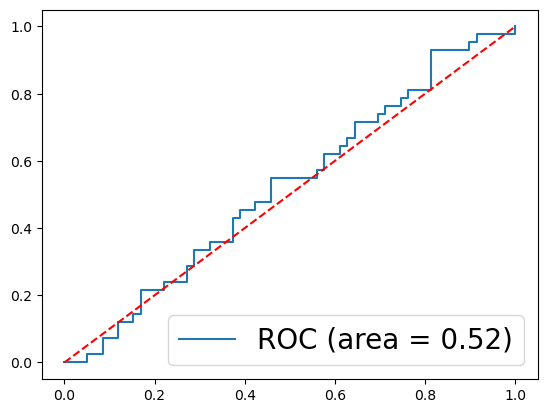

Deploy:Acc=0.571, F1=0.438, auc=0.582


/tmp/ipykernel_53059/2227552532.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train = torch.tensor(y_train,dtype=torch.int32)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


  0%|          | 1/200 [00:00<00:40,  4.86it/s]

17.461339950561523


 26%|██▌       | 51/200 [00:11<00:29,  4.98it/s]

17.311138153076172


 50%|█████     | 101/200 [00:21<00:19,  5.18it/s]

17.194276809692383


 76%|███████▌  | 151/200 [00:31<00:10,  4.82it/s]

17.171049118041992


100%|██████████| 200/200 [00:41<00:00,  4.86it/s]


0.04545454545454545
0.5217391304347826
0.5473684210526316
0.5684210526315789
0.5869565217391304
0.5869565217391304
Val: Acc=0.622, F1=0.593, auc=0.638


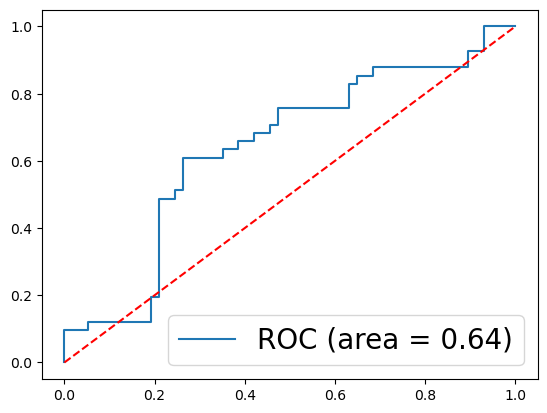

Deploy:Acc=0.259, F1=0.259, auc=0.353


/tmp/ipykernel_53059/2227552532.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train = torch.tensor(y_train,dtype=torch.int32)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


  0%|          | 1/200 [00:00<00:32,  6.05it/s]

17.111330032348633


 26%|██▌       | 51/200 [00:09<00:32,  4.57it/s]

16.920330047607422


 50%|█████     | 101/200 [00:19<00:19,  5.08it/s]

16.817224502563477


 76%|███████▌  | 151/200 [00:30<00:09,  5.40it/s]

16.776575088500977


100%|██████████| 200/200 [00:40<00:00,  4.99it/s]


0.34375000000000006
0.36363636363636365
0.3870967741935484
0.43750000000000006
0.45454545454545453
0.45454545454545453
Val: Acc=0.586, F1=0.455, auc=0.562


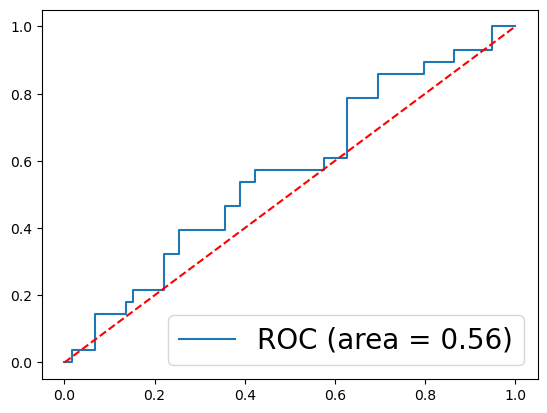

Deploy:Acc=0.571, F1=0.562, auc=0.624


/tmp/ipykernel_53059/2227552532.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train = torch.tensor(y_train,dtype=torch.int32)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


  0%|          | 1/200 [00:00<00:34,  5.81it/s]

16.793535232543945


 26%|██▌       | 51/200 [00:09<00:29,  5.02it/s]

16.51736831665039


 50%|█████     | 101/200 [00:19<00:19,  5.16it/s]

16.430801391601562


 76%|███████▌  | 151/200 [00:28<00:09,  5.31it/s]

16.36322021484375


100%|██████████| 200/200 [00:38<00:00,  5.23it/s]


0.10256410256410257
0.32558139534883723
0.4347826086956522
0.4347826086956522
0.47058823529411764
0.47058823529411764
Val: Acc=0.641, F1=0.481, auc=0.634


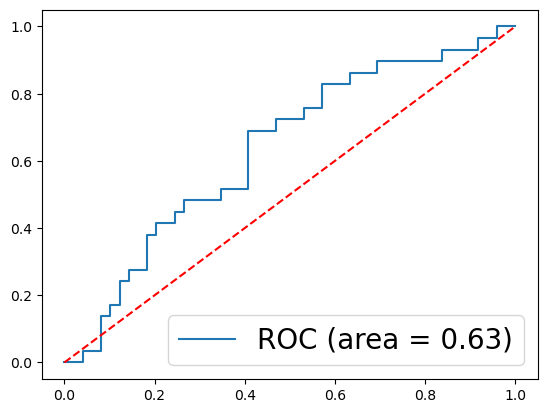

Deploy:Acc=0.554, F1=0.386, auc=0.613


/tmp/ipykernel_53059/2227552532.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train = torch.tensor(y_train,dtype=torch.int32)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


  0%|          | 1/200 [00:00<00:43,  4.61it/s]

17.704090118408203


 26%|██▌       | 51/200 [00:11<00:31,  4.68it/s]

17.50981903076172


 50%|█████     | 101/200 [00:22<00:21,  4.69it/s]

17.432085037231445


 76%|███████▌  | 151/200 [00:32<00:10,  4.56it/s]

17.341032028198242


100%|██████████| 200/200 [00:43<00:00,  4.64it/s]


0.44705882352941173
0.44705882352941173
0.44705882352941173
0.4999999999999999
0.5070422535211268
0.5070422535211268
Val: Acc=0.670, F1=0.507, auc=0.635


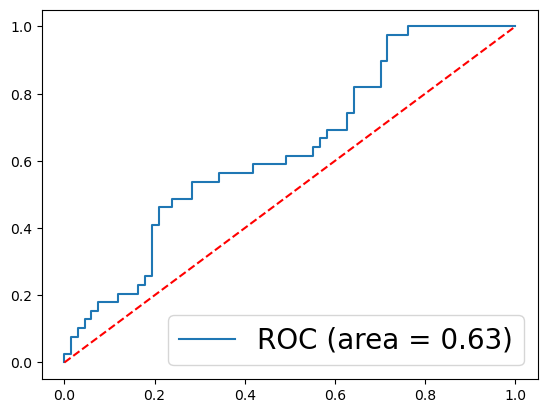

Deploy:Acc=0.538, F1=0.250, auc=0.533


/tmp/ipykernel_53059/2227552532.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train = torch.tensor(y_train,dtype=torch.int32)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


  0%|          | 1/200 [00:00<00:47,  4.23it/s]

17.548702239990234


 26%|██▌       | 51/200 [00:10<00:31,  4.78it/s]

17.490562438964844


 50%|█████     | 101/200 [00:21<00:21,  4.66it/s]

17.338302612304688


 76%|███████▌  | 151/200 [00:32<00:09,  5.07it/s]

17.311445236206055


100%|██████████| 200/200 [00:42<00:00,  4.73it/s]


0.0
0.4444444444444444
0.4594594594594595
0.48
0.48
0.48
Val: Acc=0.614, F1=0.480, auc=0.573


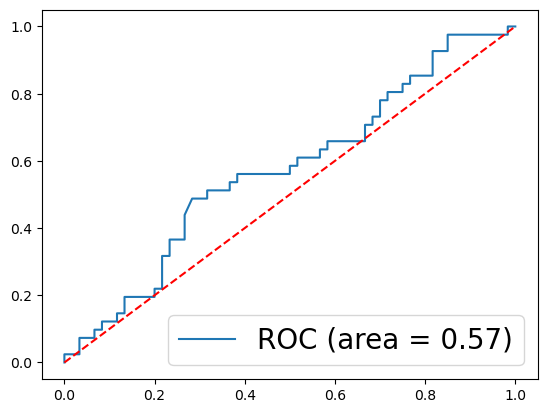

Deploy:Acc=0.568, F1=0.486, auc=0.624
In: 0.6129847799180129 0.4948094558892681 0.593982054740705
Cross: 0.5104131278373703 0.39690118915306183 0.554766350317816


In [40]:
allen_data, riaz_data, gide_data,  liu_data, hugo_data ,lee_data = load_data(genes, None)
all_data = [allen_data, riaz_data, gide_data, liu_data, hugo_data,lee_data]
for item in all_data:
    item.x_train = item.x_train[:,signs]

names = ['allen','riaz','gide','liu','hugo','lee']
train_loaders = []
val_loaders = []
accs = []
fs = []
aucs = []
vaccs = []
vfs = []
vaucs = []
for i in range(6):
    train = all_data[:i] + all_data[i+1:]
    X = torch.cat([x.x_train for x in train])
    y = torch.cat([x.y_train for x in train])
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
    input_dim = 272
    contrast_transforms = transforms.RandomChoice([normal_mixup(train_normal, 0.7), Gaussian(0.05)])
    train_data = Gene_data(X_train, y_train,transform=ContrastiveLearningViewGenerator(contrast_transforms))
    test_data = Gene_data(X_val, y_val, transform=None)
    train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True,
                                    drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)
    val_loader = data.DataLoader(test_data, batch_size=batch_size, shuffle=True,
                                    drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)
    # x_test = all_data[i]
    # x_test.x_train = x_test.x_train[:,signs]
    test_loader = data.DataLoader(all_data[i], batch_size=batch_size, shuffle=True,
                                drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)
    model = SimCLR(input_dim,emb=feat_dim, out_dim=proj_dim).to('cuda')
    model.load_state_dict(torch.load('models/simclr_tcga2.pt'))
    optimizer = torch.optim.Adam(model.parameters(), 1e-2, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200, eta_min=1e-4, last_epoch=-1)
    loss_func = SupConLoss(temperature= tmp)

    runname = f'{names[i]}-RC-AllAug-TentAll'
    trainer = Trainer(model, train_loader, val_loader, test_loader, loss_func, optimizer, \
                      scheduler, 200, batch_size, 
                        run_name=runname)

    trainer.fine_tune(i, tcga_loader)
    classify = classifier(feat_dim).to('cuda')
    va, vf, vauc = trainer.linear_probe(classify,i, 300)
    a, f, auc = trainer.test()
    accs.append(a)
    fs.append(f)
    aucs.append(auc)
    vaccs.append(va)
    vfs.append(vf)
    vaucs.append(vauc)
print("In:", np.mean(vaccs), np.mean(vfs), np.mean(vaucs))
print("Cross:", np.mean(accs), np.mean(fs), np.mean(aucs))
# trainer.tent()

# za = []
# yl = []
# model = SimCLR(input_dim,emb=feat_dim, out_dim=proj_dim).to('cuda')
# model.load_state_dict(torch.load('models/simclr1.pt'))
# model.eval()
# model.projection =nn.Identity()
# train_data = Gene_data(tcga, pd.Series(arr_nums.squeeze()),transform=None)
# train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True,
#                                 drop_last=True, pin_memory=True, \
#                                     num_workers=NUM_WORKERS)
# for i, (batch, l) in enumerate(train_loader):
#     batch = batch.to(device)
#     f = model(batch)
#     za.append(f.cpu().detach().numpy())
#     yl.append(l)
# za = np.vstack(za)
# yl = np.concatenate(yl)
# y2string = np.vectorize(num_to_word_func)(yl)
# yll = np.zeros(len(yl),)-1
# print(za.shape[0])



# brain_umap = umap.UMAP(random_state=999, n_neighbors=32, min_dist=1)
# embedding = pd.DataFrame(brain_umap.fit_transform(za), columns = ['UMAP1','UMAP2'])
# palette = sns.color_palette("bright", 36)  #Choosing color
# sns_plot = sns.scatterplot(x='UMAP1', y='UMAP2', data=embedding,
#                 hue=y2string, palette=palette,
#                 alpha=.9, linewidth=0, s=2, legend='full')

# sns_plot.legend(loc='center left', bbox_to_anchor=(1, .5), ncol=3)
# new_list = np.array(['TCGA' if x !='TCGA-SKCM' else x for x in y2string])

# allen_data, riaz_data, gide_data,  liu_data, hugo_data ,lee_data = load_data(genes, None)
# all_data = [allen_data, riaz_data, gide_data, liu_data, hugo_data,lee_data]
# names = ['allen','riaz','gide','liu','hugo','lee']

# for i in range(6):
#     X = all_data[i].x_train
#     y = all_data[i].y_train
#     print(y.shape)
#     train_data = Gene_data(X, y,transform=None)
#     train_loader = data.DataLoader(train_data, batch_size=12, shuffle=True,
#                                     drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)

#     for _, (batch, l) in enumerate(train_loader):
#         batch = batch.to(device)
#         f = model(batch)
#         za = np.vstack([za,f.cpu().detach().numpy()])
#         yll = np.concatenate([yll, l])
#         new_list= np.concatenate([new_list, np.repeat(names[i],repeats=len(l))])

# brain_umap = umap.UMAP(random_state=999, n_neighbors=32, min_dist=1)
# embedding = pd.DataFrame(brain_umap.fit_transform(za), columns = ['UMAP1','UMAP2'])
# palette = sns.color_palette("bright", 8)  #Choosing color
# sns_plot = sns.scatterplot(x='UMAP1', y='UMAP2', data=embedding,
#                 hue=new_list, palette=palette,
#                 alpha=.9, linewidth=0, s=2, legend='full')

# sns_plot.legend(loc='center left', bbox_to_anchor=(1, .5), ncol=1)